# Milestone 1: Data Pipeline Exploration

This notebook provides interactive exploration of the multi-source data pipeline:
- **PriceLoader**: Yahoo Finance OHLCV + technical features
- **FREDLoader**: Macroeconomic indicators from FRED
- **EDGARLoader**: SEC filings (10-K, 10-Q)
- **DataPipeline**: Unified data alignment

Run each cell to explore the data and verify everything works correctly.

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Load environment variables
from dotenv import load_dotenv
load_dotenv(Path.cwd().parent / '.env')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete!")

Setup complete!


---
## 1. Price Data (Yahoo Finance)

Load OHLCV data and explore technical features.

In [2]:
from data.price_loader import PriceLoader

price_loader = PriceLoader()

# Fetch SPY data
price_df = price_loader.get_price_data(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01'
)

print(f"Shape: {price_df.shape}")
print(f"Date range: {price_df.index.min()} to {price_df.index.max()}")
print(f"\nColumns: {list(price_df.columns)}")
price_df.tail()

Shape: (1006, 9)
Date range: 2020-01-02 00:00:00 to 2023-12-29 00:00:00

Columns: ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Dividends', 'Stock_Splits', 'Capital_Gains']


,Open,High,Low,Close,Adj_Close,Volume,Dividends,Stock_Splits,Capital_Gains
Date,,,,,,,,,
2023-12-22,473.859985,475.380005,471.700012,473.649994,463.589172,67160400,0.0,0.0,0.0
2023-12-26,474.070007,476.579987,473.989990,475.649994,465.546661,55387000,0.0,0.0,0.0
2023-12-27,475.440002,476.660004,474.890015,476.510010,466.388397,68000300,0.0,0.0,0.0
2023-12-28,476.880005,477.549988,476.260010,476.690002,466.564575,77158100,0.0,0.0,0.0
2023-12-29,476.489990,477.029999,473.299988,475.309998,465.213898,122283100,0.0,0.0,0.0


In [3]:
# Add technical features
price_features = price_loader.add_technical_features(price_df)

print(f"Total features: {len(price_features.columns)}")
print(f"\nNew columns added:")
new_cols = [c for c in price_features.columns if c not in price_df.columns]
for col in new_cols:
    print(f"  - {col}")

Total features: 34

New columns added:
  - return_1d
  - return_5d
  - return_21d
  - return_63d
  - log_return_1d
  - volatility_21d
  - volatility_63d
  - parkinson_vol_21d
  - vol_percentile
  - sma_20
  - sma_50
  - sma_200
  - close_to_sma20
  - close_to_sma50
  - close_to_sma200
  - sma_20_50_cross
  - sma_50_200_cross
  - rsi_14
  - macd
  - macd_signal
  - macd_hist
  - volume_sma_20
  - relative_volume
  - volume_change_5d
  - obv


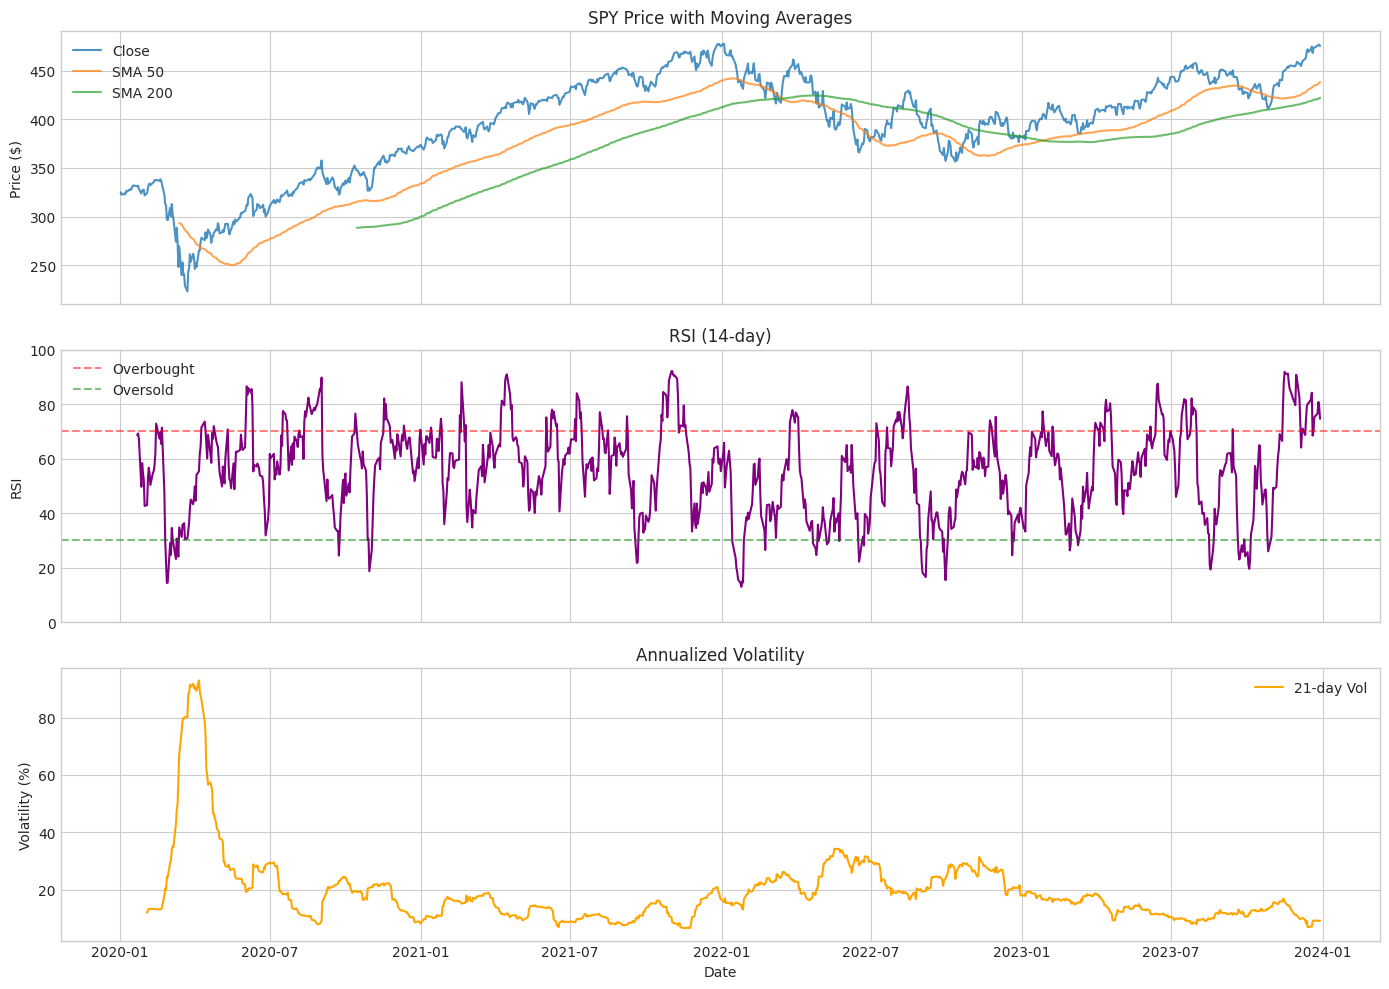

In [4]:
# Visualize price and some indicators
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Price with SMAs
ax1 = axes[0]
ax1.plot(price_features.index, price_features['Close'], label='Close', alpha=0.8)
ax1.plot(price_features.index, price_features['sma_50'], label='SMA 50', alpha=0.7)
ax1.plot(price_features.index, price_features['sma_200'], label='SMA 200', alpha=0.7)
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.set_title('SPY Price with Moving Averages')

# RSI
ax2 = axes[1]
ax2.plot(price_features.index, price_features['rsi_14'], color='purple')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought')
ax2.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.set_title('RSI (14-day)')

# Volatility
ax3 = axes[2]
ax3.plot(price_features.index, price_features['volatility_21d'] * 100, label='21-day Vol', color='orange')
ax3.set_ylabel('Volatility (%)')
ax3.set_xlabel('Date')
ax3.legend()
ax3.set_title('Annualized Volatility')

plt.tight_layout()
plt.show()

---
## 2. Macro Data (FRED)

Load macroeconomic indicators used for regime detection.

In [5]:
from data.fred_loader import FREDLoader, FRED_SERIES, DEFAULT_REGIME_SERIES

# Show available series
print("Available FRED Series:")
for series_id, description in FRED_SERIES.items():
    marker = "*" if series_id in DEFAULT_REGIME_SERIES else " "
    print(f"  {marker} {series_id}: {description}")

print(f"\n* = Default regime detection series")

Available FRED Series:
    DGS10: 10-Year Treasury Constant Maturity Rate
    DGS2: 2-Year Treasury Constant Maturity Rate
  * T10Y2Y: 10-Year Treasury Minus 2-Year Treasury (Yield Curve)
    T10Y3M: 10-Year Treasury Minus 3-Month Treasury
  * VIXCLS: CBOE Volatility Index (VIX)
  * UNRATE: Unemployment Rate
    ICSA: Initial Claims (Weekly Unemployment Claims)
  * FEDFUNDS: Federal Funds Effective Rate
    WALCL: Federal Reserve Total Assets (Balance Sheet)
  * BAA10Y: Moody's BAA Corporate Bond Yield Minus 10-Year Treasury
    TEDRATE: TED Spread (3-Month LIBOR minus 3-Month T-Bill)
    INDPRO: Industrial Production Index
    RSAFS: Retail Sales: Total
    CPIAUCSL: Consumer Price Index (All Urban Consumers)
    PCEPI: Personal Consumption Expenditures Price Index

* = Default regime detection series


In [6]:
fred_loader = FREDLoader()

# Fetch macro indicators
macro_df = fred_loader.get_macro_indicators(
    series=DEFAULT_REGIME_SERIES,
    start_date='2020-01-01',
    end_date='2024-01-01'
)

print(f"Shape: {macro_df.shape}")
print(f"Date range: {macro_df.index.min()} to {macro_df.index.max()}")
macro_df.tail(10)

Shape: (1462, 5)
Date range: 2020-01-01 00:00:00 to 2024-01-01 00:00:00


,T10Y2Y,VIXCLS,UNRATE,FEDFUNDS,BAA10Y
2023-12-23,-0.41,13.03,3.8,5.33,1.65
2023-12-24,-0.41,13.03,3.8,5.33,1.65
2023-12-25,-0.41,13.03,3.8,5.33,1.65
2023-12-26,-0.37,12.99,3.8,5.33,1.64
2023-12-27,-0.41,12.43,3.8,5.33,1.64
2023-12-28,-0.42,12.47,3.8,5.33,1.62
2023-12-29,-0.35,12.45,3.8,5.33,1.61
2023-12-30,-0.35,12.45,3.8,5.33,1.61
2023-12-31,-0.35,12.45,3.8,5.33,1.61
2024-01-01,-0.35,12.45,3.7,5.33,1.61


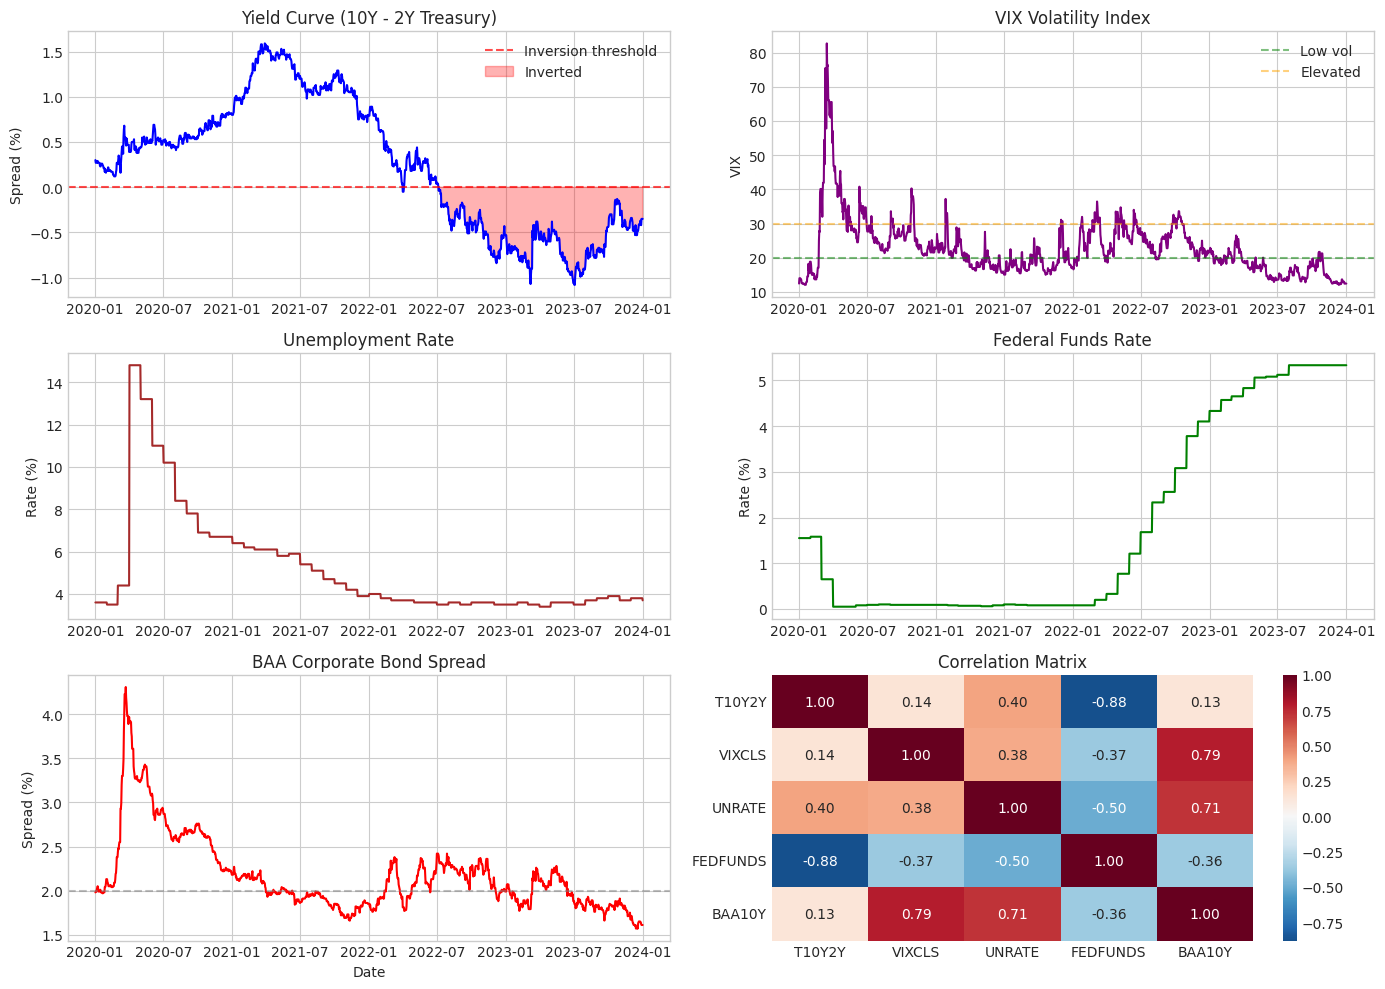

In [7]:
# Visualize key macro indicators
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Yield Curve (10Y-2Y spread)
ax = axes[0, 0]
ax.plot(macro_df.index, macro_df['T10Y2Y'], color='blue')
ax.axhline(0, color='red', linestyle='--', alpha=0.7, label='Inversion threshold')
ax.fill_between(macro_df.index, macro_df['T10Y2Y'], 0, 
                where=macro_df['T10Y2Y'] < 0, color='red', alpha=0.3, label='Inverted')
ax.set_ylabel('Spread (%)')
ax.set_title('Yield Curve (10Y - 2Y Treasury)')
ax.legend()

# VIX
ax = axes[0, 1]
ax.plot(macro_df.index, macro_df['VIXCLS'], color='purple')
ax.axhline(20, color='green', linestyle='--', alpha=0.5, label='Low vol')
ax.axhline(30, color='orange', linestyle='--', alpha=0.5, label='Elevated')
ax.set_ylabel('VIX')
ax.set_title('VIX Volatility Index')
ax.legend()

# Unemployment
ax = axes[1, 0]
ax.plot(macro_df.index, macro_df['UNRATE'], color='brown')
ax.set_ylabel('Rate (%)')
ax.set_title('Unemployment Rate')

# Fed Funds Rate
ax = axes[1, 1]
ax.plot(macro_df.index, macro_df['FEDFUNDS'], color='green')
ax.set_ylabel('Rate (%)')
ax.set_title('Federal Funds Rate')

# Credit Spread
ax = axes[2, 0]
ax.plot(macro_df.index, macro_df['BAA10Y'], color='red')
ax.axhline(2, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Spread (%)')
ax.set_title('BAA Corporate Bond Spread')
ax.set_xlabel('Date')

# Correlation heatmap
ax = axes[2, 1]
corr = macro_df.corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, ax=ax, fmt='.2f')
ax.set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

In [8]:
# Add derived features
macro_features = fred_loader.calculate_derived_features(macro_df)

print("Derived features added:")
new_cols = [c for c in macro_features.columns if c not in macro_df.columns]
for col in new_cols:
    print(f"  - {col}")

# Show yield curve inversion periods
inverted_periods = macro_features[macro_features['T10Y2Y_inverted'] == 1]
print(f"\nYield curve inverted on {len(inverted_periods)} days")
print(f"Inversion periods: {inverted_periods.index.min()} to {inverted_periods.index.max()}")

Derived features added:
  - T10Y2Y_change_1m
  - T10Y2Y_inverted
  - VIX_percentile
  - VIX_spike
  - UNRATE_change_3m
  - UNRATE_rising
  - FEDFUNDS_change_6m
  - BAA10Y_change_1m
  - BAA10Y_stress

Yield curve inverted on 549 days
Inversion periods: 2022-04-01 00:00:00 to 2024-01-01 00:00:00


---
## 3. SEC Filings (EDGAR)

Explore SEC filing data for a sample company.

In [9]:
from data.edgar_loader import EDGARLoader

edgar_loader = EDGARLoader(email="research@example.com")

# Get CIK for Apple
cik = edgar_loader.get_cik('AAPL')
print(f"Apple CIK: {cik}")

Apple CIK: 0000320193


In [10]:
# Fetch recent 10-K filings
filings = edgar_loader.get_filings(
    ticker='AAPL',
    filing_type='10-K',
    count=5
)

print(f"Found {len(filings)} 10-K filings:\n")
for f in filings:
    print(f"  {f.filing_date}: {f.filing_type}")
    print(f"    Company: {f.company_name}")
    print(f"    URL: {f.document_url[:80]}...\n")

Found 5 10-K filings:

  2025-10-31: 10-K
    Company: Apple Inc.
    URL: https://www.sec.gov/Archives/edgar/data/0000320193/000032019325000079/aapl-20250...

  2024-11-01: 10-K
    Company: Apple Inc.
    URL: https://www.sec.gov/Archives/edgar/data/0000320193/000032019324000123/aapl-20240...

  2023-11-03: 10-K
    Company: Apple Inc.
    URL: https://www.sec.gov/Archives/edgar/data/0000320193/000032019323000106/aapl-20230...

  2022-10-28: 10-K
    Company: Apple Inc.
    URL: https://www.sec.gov/Archives/edgar/data/0000320193/000032019322000108/aapl-20220...

  2021-10-29: 10-K
    Company: Apple Inc.
    URL: https://www.sec.gov/Archives/edgar/data/0000320193/000032019321000105/aapl-20210...



In [11]:
# Get filings as DataFrame (without extracting text for speed)
filings_df = edgar_loader.get_filings_dataframe(
    'AAPL',
    filing_types=['10-K', '10-Q'],
    start_date='2020-01-01',
    extract_text=False
)

print(f"Total filings: {len(filings_df)}")
print(f"\nFiling type distribution:")
print(filings_df['filing_type'].value_counts())

filings_df[['filing_date', 'filing_type', 'company_name']].head(10)

Total filings: 24

Filing type distribution:
filing_type
10-Q    18
10-K     6
Name: count, dtype: int64


,filing_date,filing_type,company_name
23,2020-01-29,10-Q,Apple Inc.
22,2020-05-01,10-Q,Apple Inc.
21,2020-07-31,10-Q,Apple Inc.
5,2020-10-30,10-K,Apple Inc.
20,2021-01-28,10-Q,Apple Inc.
19,2021-04-29,10-Q,Apple Inc.
18,2021-07-28,10-Q,Apple Inc.
4,2021-10-29,10-K,Apple Inc.
17,2022-01-28,10-Q,Apple Inc.
16,2022-04-29,10-Q,Apple Inc.


In [12]:
# Optional: Extract text from most recent filing (takes a few seconds)
# Uncomment to run

# if filings:
#     print(f"Extracting text from {filings[0].filing_date} 10-K...")
#     text_sections = edgar_loader.extract_filing_text(filings[0])
#     
#     for section, text in text_sections.items():
#         print(f"\n{section}: {len(text):,} characters")
#         print(f"Preview: {text[:500]}...")

---
## 4. Unified Data Pipeline

Load and align data from all sources.

In [13]:
from data.data_pipeline import DataPipeline

pipeline = DataPipeline()

# Load aligned data (price + macro)
aligned_df = pipeline.load_aligned_data(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01',
    include_price=True,
    include_macro=True,
    include_filings=False  # Skip for speed
)

print(f"Aligned data shape: {aligned_df.shape}")
print(f"Date range: {aligned_df.index.min()} to {aligned_df.index.max()}")

# Group columns by source
price_cols = [c for c in aligned_df.columns if c.startswith('price_')]
macro_cols = [c for c in aligned_df.columns if c.startswith('macro_')]

print(f"\nPrice features: {len(price_cols)}")
print(f"Macro features: {len(macro_cols)}")

Aligned data shape: (1462, 48)
Date range: 2020-01-01 00:00:00 to 2024-01-01 00:00:00

Price features: 34
Macro features: 14


In [14]:
# Check for missing values
missing = aligned_df.isna().sum()
missing_pct = (missing / len(aligned_df) * 100).round(2)

print("Missing values (>0%):")
print(missing_pct[missing_pct > 0].sort_values(ascending=False).head(20))

Missing values (>0%):
price_vol_percentile       49.79
price_sma_200              44.80
price_close_to_sma200      44.80
price_return_63d           35.50
price_volatility_63d       35.50
price_close_to_sma50       34.54
price_sma_50               34.54
price_return_21d           32.63
price_volatility_21d       32.63
price_parkinson_vol_21d    32.56
price_volume_sma_20        32.49
price_relative_volume      32.49
price_close_to_sma20       32.49
price_sma_20               32.49
price_rsi_14               32.08
price_return_5d            31.53
price_volume_change_5d     31.53
price_obv                  31.26
price_log_return_1d        31.26
price_return_1d            31.26
dtype: float64


In [15]:
# Create modeling dataset
X, y = pipeline.create_modeling_dataset(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01',
    target_horizon=1,
    target_type='direction'
)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts(normalize=True).round(3))

Features shape: (734, 41)
Target shape: (734,)

Target distribution:
target
0    0.591
1    0.409
Name: proportion, dtype: float64


In [16]:
# Create train/val/test split
splits = pipeline.get_train_test_split(X, y, test_ratio=0.2, val_ratio=0.1)

print("Data Splits (Time-Based):")
print("=" * 50)
for name, (X_split, y_split) in splits.items():
    print(f"\n{name.upper()}:")
    print(f"  Samples: {len(X_split):,}")
    print(f"  Date range: {X_split.index.min().date()} to {X_split.index.max().date()}")
    print(f"  Target balance: {y_split.mean():.2%} positive")

Data Splits (Time-Based):

TRAIN:
  Samples: 515
  Date range: 2021-02-01 to 2023-02-15
  Target balance: 41.17% positive

VAL:
  Samples: 73
  Date range: 2023-02-16 to 2023-06-01
  Target balance: 36.99% positive

TEST:
  Samples: 146
  Date range: 2023-06-02 to 2023-12-29
  Target balance: 41.78% positive


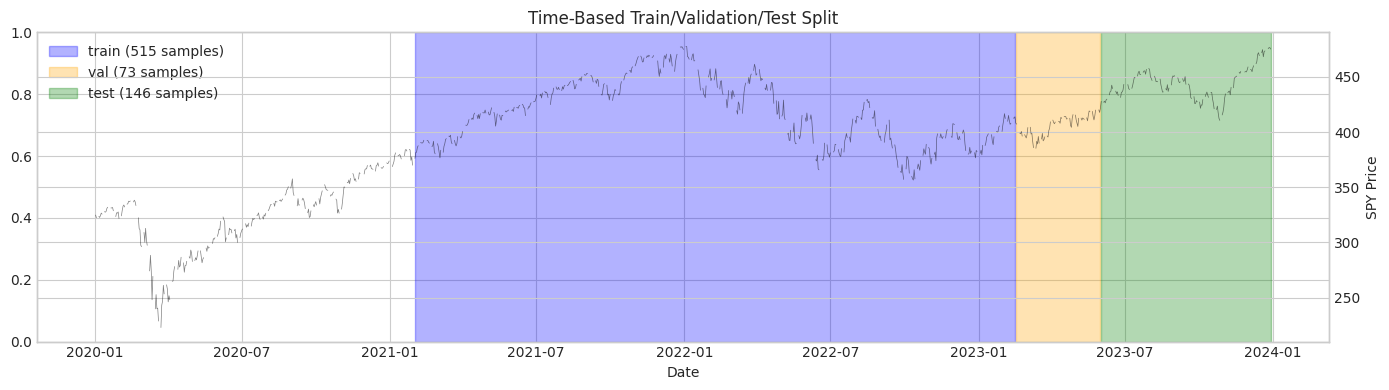

In [17]:
# Visualize train/val/test split
fig, ax = plt.subplots(figsize=(14, 4))

colors = {'train': 'blue', 'val': 'orange', 'test': 'green'}
for name, (X_split, y_split) in splits.items():
    ax.axvspan(X_split.index.min(), X_split.index.max(), 
               alpha=0.3, color=colors[name], label=f"{name} ({len(X_split)} samples)")

# Overlay price
ax2 = ax.twinx()
ax2.plot(aligned_df.index, aligned_df['price_Close'], color='black', alpha=0.5, linewidth=0.5)
ax2.set_ylabel('SPY Price')

ax.set_xlabel('Date')
ax.set_title('Time-Based Train/Validation/Test Split')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

---
## 5. Feature Analysis

Explore feature distributions and correlations.

In [18]:
# Feature statistics
X_train, y_train = splits['train']

print("Feature Statistics (Training Set):")
X_train.describe().T.head(20)

Feature Statistics (Training Set):


,count,mean,std,min,25%,50%,75%,max
price_Volume,515.0,8.435715e+07,3.119722e+07,3.054540e+07,6.146340e+07,7.797220e+07,1.008806e+08,2.517839e+08
price_Capital_Gains,515.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
price_return_1d,515.0,3.492523e-04,1.221575e-02,-4.348255e-02,-6.815865e-03,3.423051e-04,7.737498e-03,5.495435e-02
price_return_5d,515.0,1.428994e-03,2.576686e-02,-1.007118e-01,-1.285772e-02,3.196414e-03,1.667750e-02,6.899423e-02
price_return_21d,515.0,5.376096e-03,4.942358e-02,-1.280148e-01,-2.669232e-02,1.108065e-02,4.089204e-02,1.301634e-01
price_return_63d,515.0,1.635336e-02,7.111119e-02,-1.740143e-01,-3.922277e-02,4.184920e-02,7.209795e-02,1.734439e-01
price_log_return_1d,515.0,2.746807e-04,1.222363e-02,-4.445625e-02,-6.839201e-03,3.422465e-04,7.707717e-03,5.349750e-02
price_volatility_21d,515.0,1.826782e-01,6.932620e-02,6.581908e-02,1.287744e-01,1.757608e-01,2.345974e-01,3.433089e-01
price_volatility_63d,515.0,1.829783e-01,6.179038e-02,9.096814e-02,1.249612e-01,1.708275e-01,2.397599e-01,2.908709e-01
price_parkinson_vol_21d,515.0,1.460407e-01,5.294578e-02,6.410685e-02,9.900006e-02,1.476651e-01,1.868438e-01,2.604850e-01


In [19]:
# Correlation with target (on training set only)
correlations = X_train.corrwith(y_train).sort_values(key=abs, ascending=False)

print("Top 15 features correlated with target:")
print(correlations.head(15).round(4))

print("\nBottom 15 features (least correlated):")
print(correlations.tail(15).round(4))

Top 15 features correlated with target:
price_relative_volume      -0.1056
macro_UNRATE_change_3m     -0.0972
price_Volume               -0.0901
price_volatility_21d       -0.0836
price_vol_percentile       -0.0759
macro_UNRATE                0.0758
macro_T10Y2Y                0.0748
price_sma_200              -0.0747
price_sma_50_200_cross      0.0745
price_volatility_63d       -0.0698
macro_FEDFUNDS_change_6m   -0.0685
macro_T10Y2Y_inverted      -0.0602
price_close_to_sma200       0.0600
price_parkinson_vol_21d    -0.0526
price_volume_change_5d     -0.0492
dtype: float64

Bottom 15 features (least correlated):
price_sma_20_50_cross    -0.0152
price_rsi_14              0.0133
price_macd_hist          -0.0126
price_sma_20             -0.0120
price_macd_signal         0.0115
macro_VIX_spike           0.0102
price_return_21d          0.0090
price_close_to_sma20     -0.0064
price_macd                0.0064
macro_T10Y2Y_change_1m    0.0051
price_close_to_sma50      0.0041
price_volume_sma_

/home/sethz/quant-research-2025/quant-trading-advanced/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sethz/quant-research-2025/quant-trading-advanced/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


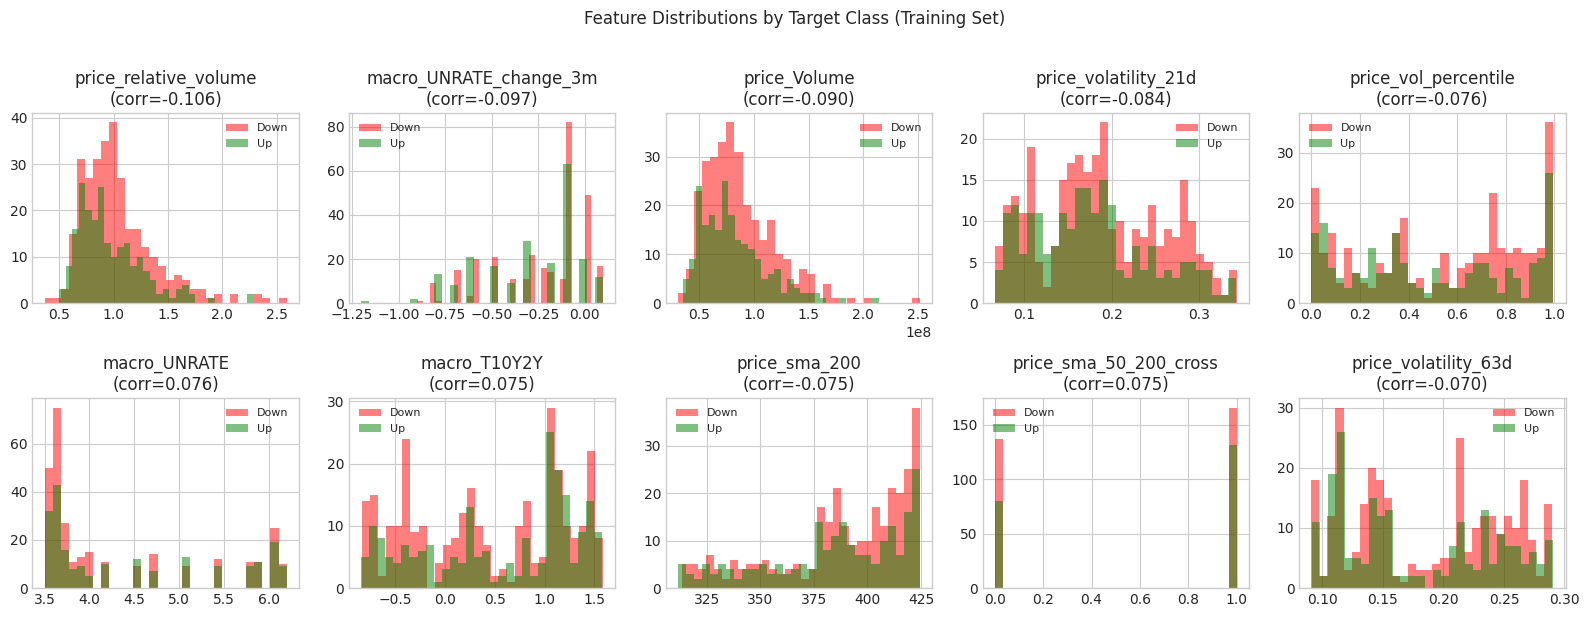

In [20]:
# Visualize top correlations
top_features = correlations.head(10).index.tolist()

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # Box plot by target class
    for label in [0, 1]:
        data = X_train.loc[y_train == label, feature].dropna()
        color = 'red' if label == 0 else 'green'
        ax.hist(data, bins=30, alpha=0.5, color=color, label=f"{'Down' if label == 0 else 'Up'}")
    
    ax.set_title(f"{feature}\n(corr={correlations[feature]:.3f})")
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions by Target Class (Training Set)', y=1.02)
plt.tight_layout()
plt.show()

---
## Summary

The data pipeline is working correctly:

1. **PriceLoader**: Successfully fetches OHLCV and computes 20+ technical features
2. **FREDLoader**: Fetches 5 key macro indicators with derived features
3. **EDGARLoader**: Can fetch and parse SEC filings
4. **DataPipeline**: Aligns all sources to daily frequency with proper time-based splits

**Next Steps**: Milestone 2 - Regime Detection using the macro indicators.